<div style="background-color: LightSalmon; border-style: solid;font-family: Arial;text-align: center">

# Predicting Weekly Online Retail Revenue Originated from France For a UK based Company 
</div>


---

<div style="background-color: Seashell; border-style: solid;font-family: Arial">
    
**Objective**
------------------
I am going to use a weekly reseampled online retail sales data originated in France for a UK based company in order to do time series forecasting; predicting T+1 based on T.

*Data Source*
-------------------
The original source of the data is:

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)

Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


*Modeling*
-------------------
I will use [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) model which works well with time series data and according to Kaggle time series competition results, it recently outperfoms XGBoost. I will tune the model using [Optuna library](https://optuna.org/) which is an an open source hyperparameter optimization framework to automate hyperparameter search. I will use the [feature engine](https://github.com/feature-engine/feature_engine) to extract some time series features.
    
</div>

---

<div style="color:black; background-color: LightSalmon; border-style: solid;font-family: Arial;text-align: center">
    
# Importing Libraries
</div>

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from feature_engine.creation import CyclicalFeatures
import lightgbm as lgb
import optuna

---

<div style="color:black; background-color: LightSalmon; border-style: solid;font-family: Arial; text-align: center">
    
# Importing Dataset
</div>

In [6]:
FILE_NAME = "../../Datasets/online_retail_dataset.csv"
df = pd.read_csv(
    FILE_NAME,
    usecols=["week", "France"],
    parse_dates=["week"],
    index_col=["week"],
)
df.columns = ['sales']

In [117]:
print("Predicting Weekly Sales where the time period is between")
df.index.max(), df.index.min()

Predicting Weekly Sales where the time period is between


(Timestamp('2011-12-11 00:00:00'), Timestamp('2009-12-20 00:00:00'))

---

<div style="color:black; background-color: LightSalmon; border-style: solid;font-family: Arial; text-align: center">
    
# Exploratory Data Analysis (EDA)

</div>

In [50]:
df.head(3)

,sales
week,
2009-12-06,3319.16
2009-12-13,2088.72
2009-12-20,975.06


In [26]:
df.shape[0]

106

106 Weeks of revenue data.

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Plot time series
    
</div>

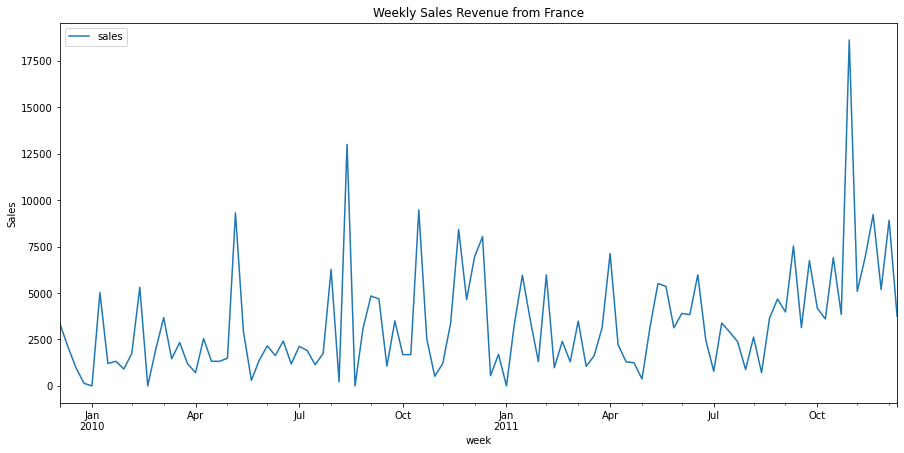

In [20]:
# Plot the time series
df.plot(figsize=(15, 7))
# Add title
plt.title("Weekly Sales Revenue from France")
# the y axis label
plt.ylabel("Sales")
plt.show()

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Missing data
    
</div>

In [22]:
df.isnull().sum()

sales    0
dtype: int64

No missing data in the dataframe.

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Missing timestamps
    
</div>


In [36]:
df.index.empty

False

In [39]:
df.index.isnull().sum()

0

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Seasonality
    
</div>


**Monthly Seasonality**

In [48]:
#Getting the month of each date and verifying the correct form
month_ = df.index.month
month_ = pd.Series(month_, index=df.index)
month_.head()

week
2009-12-06    12
2009-12-13    12
2009-12-20    12
2009-12-27    12
2010-01-03     1
Name: week, dtype: int64

Text(0.5, 0, 'Month')

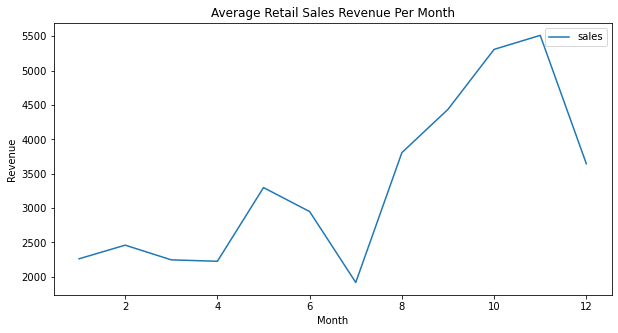

In [54]:
# Plot the average revenue
df.groupby(month_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Average Retail Sales Revenue Per Month")
plt.ylabel("Revenue")
plt.xlabel("Month")

Retail Sales increase gradually between July & November.

**Quarterly Seasonality**

In [55]:
#Getting the month of each date and verifying the correct form
quarter_ = df.index.quarter
quarter_ = pd.Series(quarter_, index=df.index)
quarter_.head()

week
2009-12-06    4
2009-12-13    4
2009-12-20    4
2009-12-27    4
2010-01-03    1
Name: week, dtype: int64

Text(0.5, 0, 'Quarter')

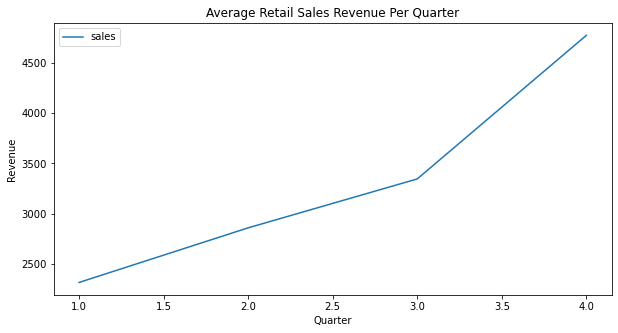

In [56]:
# Plot the average revenue
df.groupby(quarter_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Average Retail Sales Revenue Per Quarter")
plt.ylabel("Revenue")
plt.xlabel("Quarter")

Gradual sharp increase of average retail revenue per quarter increase. This signifies a quarterly seasonality.

**Week of Month**

In [57]:
weekofmonth_ = (df.index.day-1)//7+1
weekofmonth_ = pd.Series(weekofmonth_, index=df.index)
weekofmonth_.head()

week
2009-12-06    1
2009-12-13    2
2009-12-20    3
2009-12-27    4
2010-01-03    1
Name: week, dtype: int64

Text(0.5, 0, 'Week of Month')

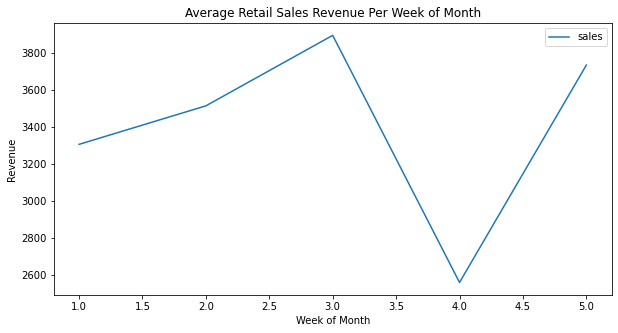

In [58]:
# Plot the average revenue
df.groupby(weekofmonth_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Average Retail Sales Revenue Per Week of Month")
plt.ylabel("Revenue")
plt.xlabel("Week of Month")

A peak towards the third and fifith week of the month.

---

<div style="color:black; background-color: LightSalmon; border-style: solid;font-family: Arial; text-align: center">
    

# Feature engineering
</div>

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## DateTime Features
    
</div>

- Quarter
- Month
- Week of Month

In [61]:
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["week_of_month"] = (df.index.day-1)//7+1

In [62]:
df.head(3)

,sales,month,week_of_month,quarter
week,,,,
2009-12-06,3319.16,12,1,4
2009-12-13,2088.72,12,2,4
2009-12-20,975.06,12,3,4


<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Lag Features
    
</div>

**Stationarity**

Before procedding in plotting the ACF and PACF which assume stationarity of the underlying time series, we shall run the stationarity test.

Staionarity can be checked through an Augmented Dickey-Fuller (ADF) unit root test:
- If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [72]:
p_value_ADF = adfuller(df.sales.values)[1]
print(" p_value = {:.7f}".format(p_value_ADF))

 p_value = 0.0000074


The **P_value** obtained is <= 0.05. Therefore, we reject the null hypothesis and the data does not have a unit root and thus is stationary.

**ACF**

The Autocorrelation Function **(ACF)** is the correlation between the current time series and the lagged values of the same time series. For example, ACF at lag 1 is the correlation between the current values at time t and the lagged values at t-1.
At lag 0, the ACF value is 1 because it is the correlation of the current values with themselves.

Figure(720x360)


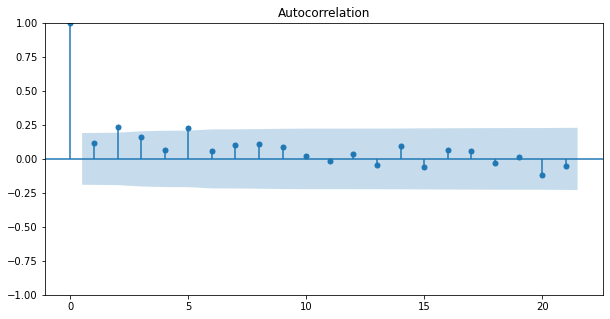

In [88]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
print(plot_acf(df.sales.values, alpha=.05, ax=ax))

**PACF**

The Partial Autocorrelation Function **(PACF)** is used to extract the correlation between the current value and eachsuccessive lagged term, considering that we take into account all the values between t and t-k. 

The partial autocorrelation at lag k is the autocorrelation between  X_t and  X_(t−k) that is not accounted for by lags 1 through  k−1.

The results can help in determining if the data can be modeled through an AR process.

Figure(720x360)


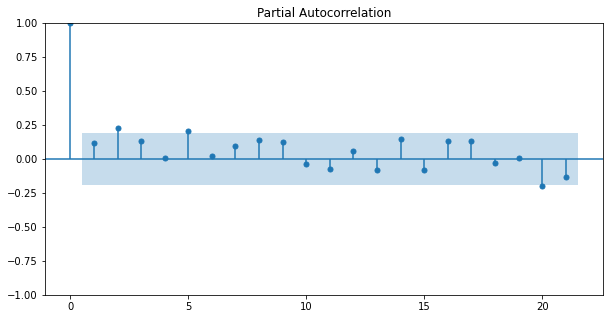

In [92]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
print(plot_pacf(df.sales.values, alpha=.05, ax=ax,  method='ols'))

We can see some slight correlation with lag 2. I will proceed with including two lags in the model as if we are about to model an AR(2) process in the form of :

$$ Y_{t} = α1Y_{t-1} + α2Y_{t−2}  $$


In [110]:
#Creating a function to create lag features
def lagged_values(df: pd.DataFrame, max_lags=2, feature="sales"):
    """This function is used to created a lagged feature of a target feature up to the maximum number of lags.
    
    Params:
    ------
        max_lags (int): The maximum number of lags to include for the target feature. 
        feature (str): The name of the target feature in the dataframe.
        df (DataFrame): The dataframe that contains the data for the target feature.
        
    returns:
    --------
        A new dataframe with the lagged valued of the target variable.
    
    """
    
    df = df.copy()
    for r in range(1, max_lags+1):
        lagged_column_name = feature + "_" + "lag_" + str(r)
        df[lagged_column_name] = df[feature].shift(periods=r, axis=0)
    
    #dropping Nan 
    df = df.dropna()
    return df 

In [112]:
df = lagged_values(df=df)
df.head(3)

,sales,month,week_of_month,quarter,sales_lag_1,sales_lag_2
week,,,,,,
2009-12-20,975.06,12,3,4,2088.72,3319.16
2009-12-27,138.75,12,4,4,975.06,2088.72
2010-01-03,0.00,1,1,1,138.75,975.06


<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Cyclical features
    
</div>

Captured through sine and consine, as this will cause the values of the features that are far apart to come closer. For example, December (12) is closer to January (1) than July (7).

In [119]:
cyclical = CyclicalFeatures(
    variables=["month", "week_of_month", "quarter"],  # The features we want to transform.
    drop_original=True,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

df.head(5)

,sales,sales_lag_1,sales_lag_2,month_sin,month_cos,week_of_month_sin,week_of_month_cos,quarter_sin,quarter_cos
week,,,,,,,,,
2009-12-20,975.06,2088.72,3319.16,-2.449294e-16,1.000000,-0.587785,-0.809017,-2.449294e-16,1.000000e+00
2009-12-27,138.75,975.06,2088.72,-2.449294e-16,1.000000,-0.951057,0.309017,-2.449294e-16,1.000000e+00
2010-01-03,0.00,138.75,975.06,5.000000e-01,0.866025,0.951057,0.309017,1.000000e+00,6.123234e-17
2010-01-10,5021.12,0.00,138.75,5.000000e-01,0.866025,0.587785,-0.809017,1.000000e+00,6.123234e-17
2010-01-17,1208.80,5021.12,0.00,5.000000e-01,0.866025,-0.587785,-0.809017,1.000000e+00,6.123234e-17


<div style="color:black; background-color: LightSalmon; border-style: solid;font-family: Arial; text-align: center">
    

# Time Series Data Splitting
</div>

In [118]:
print("Predicting Weekly Sales where the time period is between")
df.index.max(), df.index.min()

Predicting Weekly Sales where the time period is between


(Timestamp('2011-12-11 00:00:00'), Timestamp('2009-12-20 00:00:00'))

We shall leave the most recent data for test, and the remaining data for training.

**Test data:** data starting November 2011.

**Traing data:** all remaining data up until November 2011.

In [120]:
reference_date = "2011-11-01"
train_df = df[df.index < reference_date]
test_df = df[df.index >= reference_date]

In [121]:
print(f"The number of weeks for the train dataset is: {train_df.shape[0]}")
print("*******************************************************************")
print(f"The number of weeks for the test dataset is: {test_df.shape[0]}")

The number of weeks for the train dataset is: 98
*******************************************************************
The number of weeks for the test dataset is: 6


<div style="color:black; background-color: LightSalmon; border-style: solid;font-family: Arial; text-align: center">
    

# Forecasting
</div>

<div style="background-color: Seashell; border-style: solid;font-family: Arial">
    
**The popular metrics used in evaulating time series forecast are**
--------------------------------------------------------------
--------------------------------------------------------------

- Mean Absolute Error **(MAE)**
    <div style="text-align: center">
    $\sum_{i=1}^{N}|\hat{y_i}-y_i|$
    </div>                        
    
- Mean Squared Error **(MSE)**
    <div style="text-align: center">
    $\sum_{i=1}^{N}(\hat{y_i}-y_i)^2$
    </div>
    
- Root Mean Square Error **(RMSE)**
     <div style="text-align: center">
    $\sqrt{\sum_{i=1}^{N}(\hat{y_i}-y_i)^2}$
    </div>
</div>

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## Naive forecast
    
</div>


Predict sales in the next week (t) as the value of sales in the previous week (t-1).

<div style="background-color: NavajoWhite; border-style: solid;font-family: Arial">
    
## LightGBM
    
</div>

Tuning LightGBM model through using Optuna

**LightGBM**

LightGBM functions well in predicting time series tabular data and in recent Kaggle competitions, it outperforms XGBoost and other gradient boosting algorithms. 

*The advantages of using LightGBM are the following:*
- [LightGBM can use categorical features directly (without one-hot encoding). A tree built on one-hot features tends to be unbalanced and needs to grow very deep to achieve good accuracy.](https://lightgbm.readthedocs.io/en/latest/Quick-Start.html)
- [LightGBM uses histogram-based algorithms, which bucket continuous feature (attribute) values into discrete bins. This speeds up training and reduces memory usage.](https://lightgbm.readthedocs.io/en/latest/Features.html#references)
- [LightGBM grows trees leaf-wise (best-first)[7]. It will choose the leaf with max delta loss to grow. Holding #leaf fixed, leaf-wise algorithms tend to achieve lower loss than level-wise algorithms](https://lightgbm.readthedocs.io/en/latest/Features.html#references)
- [It supports the following models: regression, binary classification, multi classification, LambdaRank](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor)

In [99]:
#Initializing with some random values to check the performance before Optuna hyper-tuning of the model.
param = {
    "boosting_type": 'gbdt',
    "num_leaves": 100,
    "max_depth": 50,
    "learning_rate": 0.1,
    "n_estimators": 100
}

In [100]:
light_gbm_regress = lgb.LGBMRegressor(**param)